# CNN



<img src='https://drive.google.com/uc?Export=view&id=1fyvqBPZtdYRUi0uV6vo-z4eezhlGtq0G'>



Свертки работают примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$


<img src='https://drive.google.com/uc?export=view&id=1u2eCpOtYQgfEsnva-LTzf6Ue5NkGUhZS'>

Как реализовано в pytorch:

In [ ]:
import torch

layer = torch.nn.Conv2d(
    in_channels=2,
    out_channels=3,
    kernel_size=2,
    stride=1,
    padding=0,
    padding_mode='zeros',
    dilation=1,
    bias=True
)

In [ ]:
# 1 channel - 4 + 4 + 4
# 2 channel - 4 + 4 + 4
#             1   1   1
# 9 * 3 = 27

In [ ]:
layer.weight, layer.bias

(Parameter containing:
 tensor([[[[ 0.2446,  0.0908],
           [-0.0550,  0.1754]],
 
          [[ 0.2795, -0.1161],
           [ 0.3112,  0.1100]]],
 
 
         [[[ 0.0199, -0.1770],
           [ 0.2686,  0.0596]],
 
          [[ 0.2418,  0.3158],
           [ 0.1366,  0.1366]]],
 
 
         [[[ 0.0751, -0.0457],
           [ 0.2038, -0.1136]],
 
          [[ 0.0801, -0.3257],
           [ 0.2359, -0.2250]]]], requires_grad=True), Parameter containing:
 tensor([0.0219, 0.3084, 0.0931], requires_grad=True))

Давайте слегка коснемся следующих параметров этого слоя:

#### Padding


<img src='https://drive.google.com/uc?export=view&id=10YL2TmF0Yp56nbnPrdbVSX7ft982JMR2'>

К краям добавляются поддельные пиксели (обычно нулевого значения. За это отвечает параметр padding_mode. По дефолту он стоит "zero_padding"). За счет этого краевые пиксели могут учитываться по центру свертки. И мы можем получить выходную карту признаков такого же размера как и входная картинка.

#### Stride


<img src='https://drive.google.com/uc?export=view&id=1MXz5etAzJtzi7MudLQ-Unr0n3j0h5aso'>

бывает такое, что необходимо получить на выходе карту признаков еще меньшего размера. Для этого обычно используются Polling слои(Об этом ниже). Но например в архитектурах семейства ResNet полностью отказались от этих слоев и пользуются как раз вторым вариантом. Их называют чередующимися свертками. По сути этот параметр отвечает за шаг свертки. При 1 берутся пролеты через 1 пиксель, при 2 - пролеты через каждые 2 пикселя.

#### Dilate


<img src='https://www.mdpi.com/remotesensing/remotesensing-11-02220/article_deploy/html/images/remotesensing-11-02220-g001.png'>

Это так называемое рецептивное поле сверточного слоя. Оно расширяет пространство между элементами оригинальной свертки. Подробнее об этом можно узнать [здесь](https://towardsdatascience.com/understanding-2d-dilated-convolution-operation-with-examples-in-numpy-and-tensorflow-with-d376b3972b25)

Остальные сверточные слои реализованные в pytorch можно посмотреть [здесь](https://pytorch.org/docs/stable/nn.html#convolution-layers)

###  Cубдискритизирующий слой (Downsampling, Polling Layer)

[pytorch doc](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=pool#torch.nn.MaxPool2d)
<img src='https://www.mdpi.com/sensors/sensors-17-01535/article_deploy/html/images/sensors-17-01535-g005.png'>

В большинстве случаев, на вход такой сети приходят много маленьких матриц(обычно 2х2) и они последовательно объединяются в одно число(обычно max).


Как реализовано в pytorch:

In [ ]:
layer = torch.nn.MaxPool2d(
    kernel_size=2, 
    stride=2,
    padding=0,
    dilation=0
)

In [ ]:
layer.weight

AttributeError: ignored

Остальные пулинг слои реализованные в pytorch можно посмотреть [здесь](https://pytorch.org/docs/stable/nn.html#pooling-layers)

In [ ]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [ ]:
dataset = datasets.CIFAR10(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [ ]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 
           'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3, 32, 32])
deer


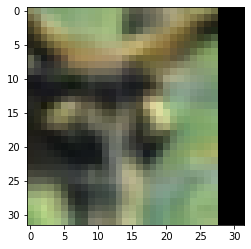

In [ ]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 10)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                   [-1, 10]             610
Total params: 191,316
Trainable params: 191,316
Non-trainable params: 0
-------------------------------

In [ ]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.018. Acc: 0.078. Test acc: 0.110
Epoch [1/5]. Step [301/372]. Loss: 0.015. Acc: 0.288. Test acc: 0.402
Epoch [2/5]. Step [1/372]. Loss: 0.013. Acc: 0.422. Test acc: 0.344
Epoch [2/5]. Step [301/372]. Loss: 0.013. Acc: 0.393. Test acc: 0.478
Epoch [3/5]. Step [1/372]. Loss: 0.013. Acc: 0.367. Test acc: 0.466
Epoch [3/5]. Step [301/372]. Loss: 0.012. Acc: 0.444. Test acc: 0.490
Epoch [4/5]. Step [1/372]. Loss: 0.011. Acc: 0.484. Test acc: 0.512
Epoch [4/5]. Step [301/372]. Loss: 0.011. Acc: 0.477. Test acc: 0.527
Epoch [5/5]. Step [1/372]. Loss: 0.013. Acc: 0.469. Test acc: 0.530
Epoch [5/5]. Step [301/372]. Loss: 0.011. Acc: 0.496. Test acc: 0.521
Training is finished!


## Предобученные сети

https://www.kaggle.com/julichitai/gb-asl-alphabet-classification-pytorch

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary
summary(resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
for param in list(resnet18.parameters())[:]:
    param.requires_grad = False

In [ ]:
resnet18.fc = nn.Linear(512, 10)

summary(resnet18.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
resnet18 = resnet18.to(device)

In [ ]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [ ]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 5
resnet18.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet18.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet18(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet18.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.018. Acc: 0.195. Test acc: 0.151
Epoch [1/5]. Step [301/372]. Loss: 0.008. Acc: 0.677. Test acc: 0.778
Epoch [2/5]. Step [1/372]. Loss: 0.005. Acc: 0.781. Test acc: 0.782
Epoch [2/5]. Step [301/372]. Loss: 0.005. Acc: 0.765. Test acc: 0.798
Epoch [3/5]. Step [1/372]. Loss: 0.005. Acc: 0.828. Test acc: 0.790
Epoch [3/5]. Step [301/372]. Loss: 0.005. Acc: 0.772. Test acc: 0.786
Epoch [4/5]. Step [1/372]. Loss: 0.005. Acc: 0.805. Test acc: 0.794
Epoch [4/5]. Step [301/372]. Loss: 0.005. Acc: 0.774. Test acc: 0.809
Epoch [5/5]. Step [1/372]. Loss: 0.006. Acc: 0.711. Test acc: 0.802
Epoch [5/5]. Step [301/372]. Loss: 0.005. Acc: 0.782. Test acc: 0.812
Training is finished!


## Аугментация данных

### Модуль transforms

Так как очень много работ связано непосредственно с изображениями, то у нас зачастую бывает что изображений либо мало, либо мы их должны как-то преобразовывать, либо мы хотим как-то расширить наш датасет. Тогда мы можем воспользоваться методами transforms, реализованным в библиотеке torchvision. 

Какие у него особенности?
 - Не со всеми форматами изображений он работает. Нам нужно преобразовывать наши изображения в формат изображений библиотеки PIL
 

https://pytorch.org/vision/stable/transforms.html

In [ ]:
from scipy import misc
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


img = Image.fromarray(misc.face())

In [ ]:
type(img)

PIL.Image.Image

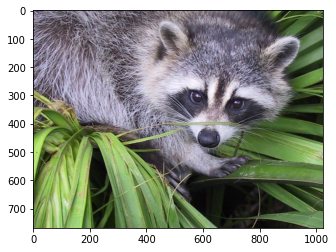

In [ ]:
plt.imshow(img)
plt.show()

Благодаря методам из transforms мы можем видоизменять наши изображения. Например поворачивать, вырезать и т.д.

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop((100, 100)), # рандомно вырезает из картинки картинку размера 100х100
        # transforms.ToTensor() # нужно для работы с нейронными сетями, но не будет отображаться через plt
        ])

In [ ]:
img_crop = data_transforms(img)

In [ ]:
type(img_crop)

PIL.Image.Image

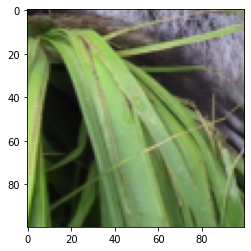

In [ ]:
plt.imshow(img_crop)
plt.show()

Так же мы можем создавать не по одному трансформу, а по несколько композицию (от сюда слово Compose). Метод Compose принимает список из трансформов.

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(size=(255, 255), ),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=2, contrast=2),
    transforms.CenterCrop(size=224)
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        # std=[0.229, 0.224, 0.225])
])

In [ ]:
img_center_crop = transformations(img)

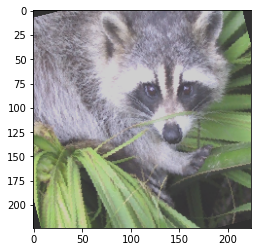

In [ ]:
plt.imshow(img_center_crop)
plt.show()

### [Albumentations](https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb)

https://albumentations.ai/

In [ ]:
import albumentations as alb
# from albumentations.pytorch import ToTensor
import numpy as np


alb_transform = alb.Compose(
    [
        alb.Resize(height=256, width=256),
        alb.RandomCrop(height=224, width=224),
        alb.HorizontalFlip(p=0.5),
        alb.SmallestMaxSize(max_size=160),
        alb.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),
        alb.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        alb.RandomBrightnessContrast(p=0.5),
        alb.OneOf([
            alb.MotionBlur(p=1),
            alb.OpticalDistortion(p=1),
            alb.GaussNoise(p=1)                 
        ], p=1),
        alb.Normalize(mean=(0.485, 0.456, 0.406),
                      std=(0.229, 0.224, 0.225)),
        # ToTensor(),
    ]
)

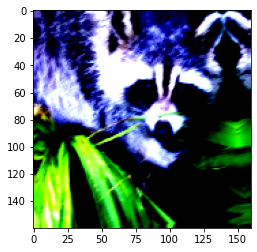

In [ ]:
alb_img = alb_transform(image=np.array(img))['image']
plt.imshow(alb_img)

## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.